In [2]:
import sys
sys.path.append('/Users/reketejmakrety/Documents/projects/multistate_dynamical_processes_networks')
import numpy as np
import matplotlib.pyplot as plt
from multistate_processes.barabasi_albert import BarabasiAlbert
from multistate_processes.process import MultistateProcess
from multistate_processes.simulate import SimulateProcess
from multistate_processes.meanField import omega, mult
from itertools import product

In [6]:
N = 100
n = 3
num_infected = 3

network = BarabasiAlbert(N, 2)

rate_matrix = np.array([
    ['0', 'beta*{1}', '0'], 
    ['0', '0', 'gamma'], 
    ['0', '0', '0']
])

sir_process = MultistateProcess(rate_matrix, gamma=0.02, beta=0.02)

states = [0] * N
infected_nodes = np.random.choice(list(range(N)), num_infected).tolist()

for i in infected_nodes[:-1]:
    states[i] = 1

states[infected_nodes[-1]] = 2

In [7]:
T = 250
degree_distribution, bin_edges = network.degree_distribution()
X = np.zeros((T, n, int(network.k_max)))

degrees = network.degrees_list
for node in range(N):
    X[0][states[node]][degrees[node] - 1] += 1

X = np.nan_to_num(X / np.sum(X[0], axis=0))
for t in range(1, T):
    for k in range(1, network.k_max):
        X[t].T[k] = X[t - 1].T[k]
        all_ms = [list(h) for h in list(product(range(k + 2), repeat=n)) if sum(h) == k + 1]
        for m in all_ms:
            X[t].T[k] -= (sir_process.R(m) -  sir_process.F(m).T) * mult(X[t - 1], k + 1, m, network) @ X[t - 1].T[k]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


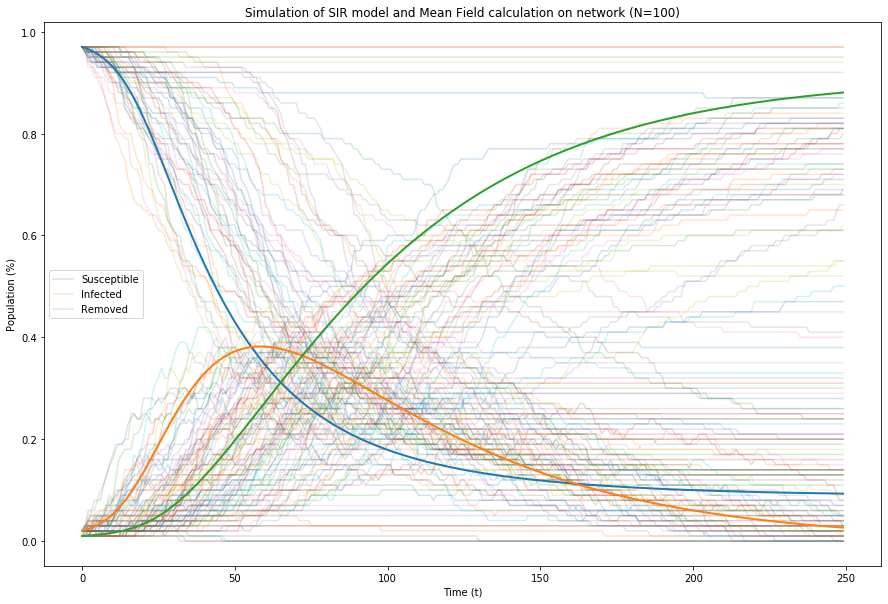

In [8]:
plt.figure(figsize=(15, 10))
for h in range(50):
    sir = SimulateProcess(network, sir_process, states)

    Z = np.zeros((T, N))
    S = np.zeros((T, n))

    Z[0] = sir.states
    S[0] = np.array([N - num_infected, num_infected - 1, 1])


    iterate_sir = iter(sir)
    for i in range(1, T):
        Z[i] = next(iterate_sir)
        S[i] = np.histogram(Z[i], bins=list(range(n + 1)))[0]
    
    plt.plot(np.arange(T), S / N, alpha=0.2)

plt.plot(np.arange(T), X @ degree_distribution, linewidth=2)
plt.ylabel('Population (%)')
plt.xlabel('Time (t)')
plt.title(f'Simulation of SIR model and its Mean Field calculation on network (N={N})')
plt.legend(['Susceptible', 'Infected', 'Removed'])
plt.show()